In [1]:
import time
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def convert(y):
    num_classes = 10
    num_examples = len(y)
    one_hot = np.zeros((num_classes, num_examples))
    one_hot[y, np.arange(num_examples)] = 1
    return one_hot

In [3]:
from mlxtend.data import loadlocal_mnist
train_x_orig, train_y = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')

test_x_orig, test_y = loadlocal_mnist(
        images_path='t10k-images.idx3-ubyte',
        labels_path='t10k-labels.idx1-ubyte')

#reshape data
train_x_orig = np.reshape(train_x_orig, (train_x_orig.shape[0],28,28))
test_x_orig = np.reshape(test_x_orig, (test_x_orig.shape[0],28,28))

#labels
train_y = convert(train_y)
test_y = convert(test_y)

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (784, 60000)
test_x's shape: (784, 10000)
train_y's shape: (10, 60000)
test_y's shape: (10, 10000)


In [13]:
def read(x):
    return int(np.where(x == 1)[0])


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ


def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=0)
    

def cross_entropy(logits, labels):
    y = labels.argmax(axis=1)
    m = y.shape[0]
    p = softmax(logits)
    log_likehood = -np.log(p[range(m),y])
    loss = np.sum(log_likehood) / m
    return loss
    
    
def delta_cross_entropy(logits, labels):
    y = labels.argmax(axis=1)
    m = y.shape[0]
    grad = softmax(logits)
    grad[range(m),y] -= 1
    grad = grad / m
    return grad


def initialize_adam(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)

    return v, s


def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    z1 = W1.dot(X) + b1
    a1, c = relu(z1)
    z2 = W2.dot(a1) + b2
    
    cache = (X, W1, b1, z1, a1, W2, b2, z2)
    
    return z2, cache


def backward_propagation(a2, Y, cache):
    (X, W1, b1, z1, a1, W2, b2, z2) = cache
    grads = {}
    
    dA2 = softmax(a2) - Y
    m = dA2.shape[1]
    dW2 = (np.dot(dA2,a1.T))/m
    db2 = np.sum(dA2,axis=1,keepdims=True)/m
    dA1 = np.dot(W2.T,dA2)
    
    dZ1 = relu_backward(dA1, z1)
    m = dZ1.shape[1]
    dW1 = (np.dot(dZ1,X.T))/m
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m
    dA0 = np.dot(W1.T,dZ1)
    
    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    
    return grads


def update_parameters_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                           beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v['dW' + str(l+1)] = beta1 * v['dW' + str(l+1)] + (1-beta1) * grads['dW' + str(l+1)]
        v['db' + str(l+1)] = beta1 * v['db' + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]
        
        v_corrected['dW' + str(l+1)] = v['dW' + str(l+1)] / (1-beta1**t)
        v_corrected['db' + str(l+1)] = v['db' + str(l+1)] / (1-beta1**t)
        
        s['dW' + str(l+1)] = beta2 * s['dW' + str(l+1)] + (1-beta2) * grads['dW' + str(l+1)]**2
        s['db' + str(l+1)] = beta2 * s['db' + str(l+1)] + (1-beta2) * grads['db' + str(l+1)]**2
        
        s_corrected['dW' + str(l+1)] = s['dW' + str(l+1)] / (1-beta2**t)
        s_corrected['db' + str(l+1)] = s['db' + str(l+1)] / (1-beta2**t)
        
        parameters['W' + str(l+1)] = parameters['W'+str(l+1)] - learning_rate * v_corrected['dW' + str(l+1)] / (np.sqrt(s_corrected['dW' + str(l+1)]) + epsilon)
        parameters['b' + str(l+1)] = parameters['b'+str(l+1)] - learning_rate * v_corrected['db' + str(l+1)] / (np.sqrt(s_corrected['db' + str(l+1)]) + epsilon)
        
    return parameters, v, s


def predict(X, y, parameters):
    z2, cache = forward_propagation(X, parameters)
    test_loss = cross_entropy(z2, y)
    pred = np.max(softmax(z2),axis=0,keepdims=1) == softmax(z2)
    correct = np.sum(pred == y)
    print("test loss = %e, test accuracy = %f" %(test_loss, 100. * (correct/X.shape[1]/10)))
    
    
def random_mini_batch(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    num_complete_minibatches = math.floor(m / mini_batch_size)
    
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [5]:
def model(X, Y, layers_dims, learning_rate = 0.007, mini_batch_size = 64, beta1 = 0.9,
          beta2 = 0.999, epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    parameters = initialize_parameters(n_x, n_h, n_y)
    v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batch(X, Y, mini_batch_size, seed)
        cost_total = 0
        for mb in minibatches:
            (mbx, mby) = mb
            z2, caches = forward_propagation(mbx, parameters)
            cost_total += cross_entropy(z2, mby)
            grads = backward_propagation(z2, mby, caches)
            t = t + 1
            parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        cost_avg = cost_total / m
        if print_cost and i % 5 == 0:
            print ("Cost after each epoch %i: %f" %(i, cost_avg))
            costs.append(cost_avg)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    return parameters

Cost after each epoch 0: 0.002209
Cost after each epoch 5: 0.000807
Cost after each epoch 10: 0.000529
Cost after each epoch 15: 0.000767
Cost after each epoch 20: 0.000490
Cost after each epoch 25: 0.000590
Cost after each epoch 30: 0.000493
Cost after each epoch 35: 0.000265
Cost after each epoch 40: 0.000408
Cost after each epoch 45: 0.000237
Cost after each epoch 50: 0.000380
Cost after each epoch 55: 0.000378


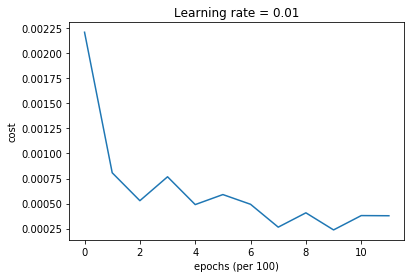

In [12]:
layers_dims = (784,500,10)
parameters = model(train_x, train_y, layers_dims, learning_rate = 0.01, mini_batch_size = 100, num_epochs = 59)

In [14]:
predict(train_x, train_y, parameters)
predict(test_x, test_y, parameters)

test loss = 0.000000e+00, test accuracy = 99.974333
test loss = 4.406253e-12, test accuracy = 99.588000
